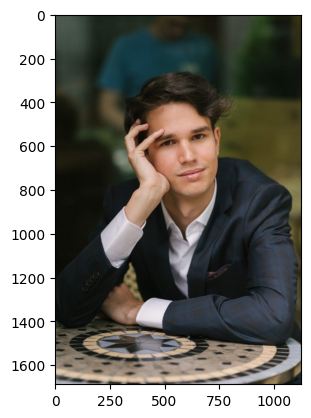

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


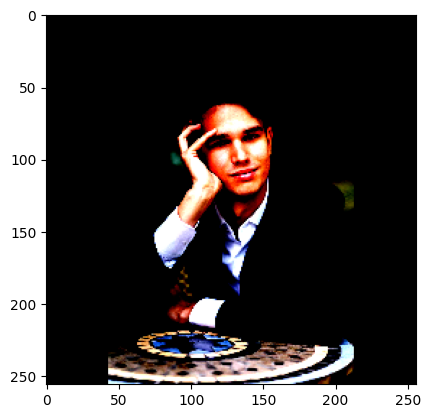

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


delta_pixels 42


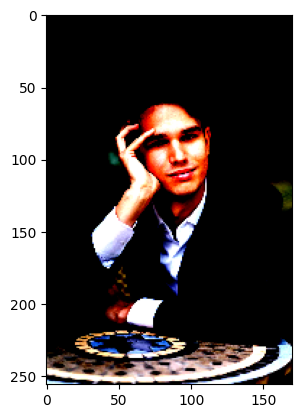

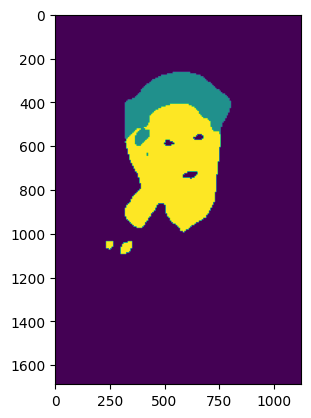

In [1]:
import cv2
import numpy as np
import torch
import albumentations as albu
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

# Define the classes and image dimensions
CLASSES = ["background", "hair", "skin"]
INFER_WIDTH = 256
INFER_HEIGHT = 256

# Define the normalization statistics for ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Define the device to use for computations
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the JIT model
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

# Define the augmentations
def get_validation_augmentation():
    test_transform = [
        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
        albu.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
    return albu.Compose(test_transform)

# Load the image
image_path = 'im.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_height, original_width, _ = image.shape

plt.imshow(image)
plt.show()

# Apply the augmentations
augmentation = get_validation_augmentation()
augmented = augmentation(image=image)
image_transformed = augmented['image']

# Convert the image to a PyTorch tensor and move it to the device
x_tensor = torch.from_numpy(image_transformed).to(DEVICE).unsqueeze(0).permute(0, 3, 1, 2).float()

# Run the image through the model
best_model.eval()
with torch.no_grad():
    pr_mask = best_model(x_tensor)

# Convert the output to a numpy array and remove the batch dimension
pr_mask = pr_mask.squeeze().cpu().detach().numpy()

# Get the class with the highest probability for each pixel
label_mask = np.argmax(pr_mask, axis=0)

plt.imshow(image_transformed)
plt.show()

# Опредяем сколько пикселей появится по бокам от паддингов и далее вырежем их
if original_height > original_width:
    delta_pixels = int(((original_height-original_width)/2)/original_height * INFER_HEIGHT)
    print('delta_pixels', delta_pixels)
    image_cropped = image_transformed[:, delta_pixels + 1: INFER_WIDTH - delta_pixels - 1]
    mask_cropped = label_mask[:, delta_pixels + 1 : INFER_WIDTH - delta_pixels - 1]
elif original_height < original_width:
    delta_pixels = int(((original_width-original_height)/2)/original_width * INFER_WIDTH)
    print('delta_pixels', delta_pixels)
    image_cropped = image_transformed[delta_pixels + 1: INFER_HEIGHT - delta_pixels - 1, :]
    mask_cropped = label_mask
else:
    mask_cropped = label_mask
    image_cropped = image_transformed

plt.imshow(image_cropped)
plt.show()

# Resize the mask back to the original image size
label_mask_real_size = cv2.resize(mask_cropped, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

# Print the mask
plt.imshow(label_mask_real_size)
plt.show()


In [ ]:
%matplotlib widget

In [ ]:
from ipywidgets import interact, IntSlider

# Преобразуйте изображение в HSV и разделите его на каналы
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
h, s, v = cv2.split(image_hsv)

# Создайте функцию для обработки изображения с помощью ipwidgets
def adjust_hsv(h_adjust=0, s_adjust=0, v_adjust=0):
    # Создайте копии каналов HSV для изменений
    h_adjusted = np.copy(h)
    s_adjusted = np.copy(s)
    v_adjusted = np.copy(v)
    
    # Примените изменения только к пикселям, где маска равна 1
    mask_indices = np.where(label_mask_real_size == 1)
    h_adjusted[mask_indices] = np.clip(h_adjusted[mask_indices] + h_adjust, 0, 179)
    s_adjusted[mask_indices] = np.clip(s_adjusted[mask_indices] + s_adjust, 0, 255)
    v_adjusted[mask_indices] = np.clip(v_adjusted[mask_indices] + v_adjust, 0, 255)
    ыы
    # Объедините каналы HSV обратно в одно изображение
    image_hsv_adjusted = cv2.merge([h_adjusted, s_adjusted, v_adjusted])
    
    # Преобразуйте изображение обратно в RGB для отображения
    image_rgb_adjusted = cv2.cvtColor(image_hsv_adjusted.astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    # Отобразите изображение
    plt.imshow(image_rgb_adjusted)
    plt.axis('off')
    plt.show()

# Создайте ползунки для корректировки параметров HSV
h_slider = IntSlider(min=-179, max=179, step=1, value=0, description='Hue Adjust:')
s_slider = IntSlider(min=-255, max=255, step=1, value=0, description='Saturation Adjust:')
v_slider = IntSlider(min=-255, max=255, step=1, value=0, description='Value Adjust:')

# Используйте interact для создания интерактивного виджета
interact(adjust_hsv, h_adjust=h_slider, s_adjust=s_slider, v_adjust=v_slider)